# Getting started with MolPipeline

This notebook shows the setup and training of a machine learning model with MolPipeline to predict molecular properties. MolPipeline combines RDKit with Sklearn using Sklearn's [Pipeline](https://scikit-learn.org/stable/modules/compose.html) concepts for consistent molecular machine learning. This includes:

* Reading molecule data files
* Standardizing molecules
* Featurization
* Machine learning model training


In [1]:
import numpy as np

from molpipeline import Pipeline
from molpipeline.any2mol import AutoToMol
from molpipeline.mol2any import MolToFoldedMorganFP
from molpipeline.mol2mol import (
    ElementFilter,
    MetalDisconnector,
    SaltRemover,
    StereoRemover,
    SolventRemover,
    TautomerCanonicalizer,
    Uncharger,
)

from rdkit import Chem

from sklearn.ensemble import RandomForestRegressor

## Setting up a simple pipeline for property prediction <a class="anchor" id="simplepipeline"></a>

A pipeline consist of pipeline elements. Each pipeline element complies with the Sklearn API. Therefore, Molpipeline's elements are implementing the well-known fit, fit_transform, predict, etc. functions of the Sklearn interface.

In the following example we first introduce the different pipeline elements and then compose them in a Pipeline that we can execute.

### Reading molecular data

Using RDKit's rich functionalities MolPipeline can read various molecular input formats. The AutoToMol pipeline element creates RDKit molecules automatically without the need to specify the input format manually. For example, SMILES, SDF or binary serialized molecules (coming from RDKit's mol.ToBinary() function) are supported. But there are also dedicated pipeline elements like SmilesToMol to read molecules from SMILES.

In [2]:
auto2mol = AutoToMol()

Transformer pipeline elements transform a given input list to an ouput list. All we have to do is call the transform function

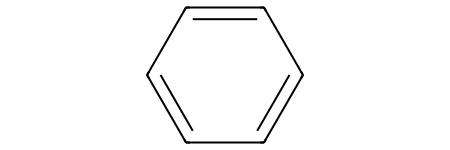

In [3]:
mols = auto2mol.transform(["c1ccccc1"])
mols[0]

The AutoToMol element can also read other molecule formats like SDF  

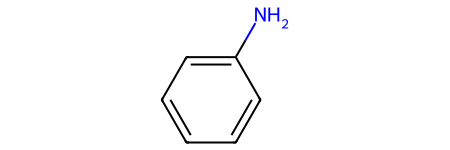

In [4]:
from io import StringIO
from rdkit import rdBase

sio = StringIO()
with rdBase.BlockLogs():
    with Chem.SDWriter(sio) as w:
        w.write(Chem.MolFromSmiles("c1ccccc1N"))
    sdf_string = sio.getvalue()
    mol2 = auto2mol.transform([sdf_string])[0]
mol2

Let's add the element to a list for later.

In [5]:
read_elements = [("auto2mol", AutoToMol())]

### Standardizing molecules

Usually, many applications and algorithms requiere that molecules are in a particular form. However, molecule data comes in diverse forms and with heterogenous annotations. Therefore, molecule standardization is often necessary. In MolPipeline there are pipeline elements that directly wrap certain RDKit functionalities for standardization which can be used to simply setup custom standardization pipelines. 

We can filter molecules by the elements they contain with the ElementFilter.

In [6]:
# we can say that we only want molecules with carbon, nitrogen and oxygen
element_filter = ElementFilter(allowed_element_numbers=[6, 7, 8])

The following will substitute the second molecule with the Flour atom with an `InvalidInstance` which marks the molecule as invalid (see the notebook on error handling for more details). By replacing the filtered value instead of removing it, the entries of the output list and input list correspond to each other and are mappable because they have the same length.

In [7]:
mols = auto2mol.transform(["CCC", "CCCF"])
element_filter.transform(mols)

 InvalidInstance(ElementFilter, Molecule contains following forbidden elements: {9})]

The elements allowed by default are:

In [8]:
ElementFilter().allowed_element_numbers

{1, 5, 6, 7, 8, 9, 14, 15, 16, 17, 34, 35, 53}

Besides filtering, we can also standardize the molecules by removing unwanted metals, salts, stereo information and the molecules' charge and compute a canonical tautomer. In contrast to the ElementFilter these pipeline element don't filter out molecules but transform them to different molecules (if possible).

In [9]:
metal_disconnector = MetalDisconnector()
salt_remover = SaltRemover()
uncharge = Uncharger()
canonical_tautomer = TautomerCanonicalizer()
stereo_remover = StereoRemover()

For example, the `SaltRemover` can remove salts from a mixture. This node simply wrappes RDKit's [SaltRemover](https://www.rdkit.org/docs/source/rdkit.Chem.SaltRemover.html) into a Sklearn-like pipeline element.

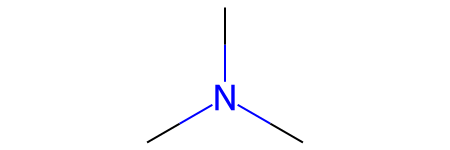

In [10]:
mols = auto2mol.transform(["CN(C)C.Cl"])
salt_remover.transform(mols)[0]

Let's add the standardization elements to a list for later.

In [11]:
standardization_elements = [
    ("element_filter", ElementFilter()),
    ("metal_disconnector", MetalDisconnector()),
    ("salt_remover", SaltRemover()),
    ("uncharge", Uncharger()),
    ("canonical_tautomer", TautomerCanonicalizer()),
    ("stereo_remover", StereoRemover()),
]

### Feature computation

RDKit provides a wealth of useful molecular descriptors. Here we use the popular [Morgan (or ECFP) fingerprints](https://www.rdkit.org/docs/GettingStartedInPython.html#rdkit-topological-fingerprints) which can be directly computed using the `MolToFoldedMorganFP` pipeline element. 

In [12]:
morgan2_2048 = MolToFoldedMorganFP(n_bits=2048, radius=2)

Let's create Morgan fingerprints for some molecules. By default the returned feature matrix is sparse which uses much less memory for big data sets.

In [13]:
mols = auto2mol.transform(["c1ccccc1", "c1ccccc1N"])
morgan2_2048.transform(mols)

<2x2048 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in Compressed Sparse Row format>

However, we can also directly generate a dense matrix

In [14]:
morgan2_2048 = MolToFoldedMorganFP(n_bits=2048, radius=2, return_as="dense")
mols = auto2mol.transform(["c1ccccc1", "c1ccccc1N"])
morgan2_2048.transform(mols)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Let's store the featurization elements for later:

In [15]:
featurization_elements = [("morgan2_2048", MolToFoldedMorganFP(n_bits=2048, radius=2))]

### Machine learning model

We can use machine learning estimators from Sklearn natively with MolPipeline because they implement the same API/interface.

In [16]:
ml_models = [("RandomForestRegressor", RandomForestRegressor(random_state=67056))]

### Putting the pipeline together

The presented pipeline elements can easily composed into a full Pipeline. The pipeline's elements will be executed subsequently. In the following example, first, the given input SMILES will be read to RDKit molecules, then they are standardized and fingerprints are computed. The fingerprints are finally used to fit the RandomForestRegressor.

In [17]:
pipeline = Pipeline(
    read_elements + standardization_elements + featurization_elements + ml_models
)

# fit the pipeline with dummy data
pipeline.fit(X=["CCCCCC", "c1ccccc1"], y=[0.2, 0.4])

Pipeline(steps=[('auto2mol', AutoToMol()),
                ('element_filter',
                 ElementFilter(allowed_element_numbers={1, 34, 35, 5, 6, 7, 8, 9, 14, 15, 16, 17, 53})),
                ('metal_disconnector', MetalDisconnector()),
                ('salt_remover', SaltRemover()), ('uncharge', Uncharger()),
                ('canonical_tautomer', TautomerCanonicalizer()),
                ('stereo_remover', StereoRemover()),
                ('morgan2_2048', MolToFoldedMorganFP()),
                ('RandomForestRegressor',
                 RandomForestRegressor(random_state=67056))])

Just like in Sklearn we now have an estimator as a pipeline that not only contains the machine learning model but also the transformation steps to go from the raw molecular data to the trained model. With this pipeline we can make predictions for new molecules:

In [18]:
pipeline.predict(["CCC"])

array([0.298])

Instead of training a machine learning model, we can also compose the elements to make a pipeline that computes the molecular fingerprint matrix.